**Задание:**

* Выберите одну из зон среди отобранных на прошлой неделе, возьмите по ней все подготовленные данные о количестве поездок. Не используйте данные за последний имеющийся месяц — июнь 2016! Создайте регрессионные признаки для учёта сезонностей и трендов.
* Чтобы примерно подобрать порядки дифференцирования ряда в модели ARIMA, сделайте регрессию целевого признака — количества поездок — на построенные признаки. Посмотрите на остатки регрессии. Если регрессионные признаки подобраны идеально, то в них должна остаться только внутрисуточная сезонность. Вслепую идеально подобрать признаки вам вряд ли удастся, так что в остатках вы, скорее всего, увидите много интересного, в том числе праздники, аномалии, тренды и многое другое.
* Чтобы подобрать значения гиперпараметров ARIMA, попробуйте сделать ряд остатков стационарным. Если необходимо, сделайте несколько дифференцирований. Из-за большого количества аномальных дней (праздники и т.д.) вряд ли вам удастся сделать так, что критерий Дики-Фуллера не будет отвергать гипотезу нестационарности, поэтому при выборе порядка дифференцирования ориентируйтесь в первую очередь на результат STL-декомпозиции.
* Постройте ACF и PACF полученного ряда остатков (возможно, продифференцированных) с максимальным лагом не меньше длины самого длинного сезонного периода (неделя или год), подберите по ним начальные приближения для параметров p, q, P, Qp,q,P,Q. Используйте эти начальные приближения при переборе моделей ARIMA исходного ряда, не забывая подавать функции SARIMAX регрессионные признаки в качестве параметра exog.
* Выберите оптимальную по AIC модель; постройте график исходного ряда и нарисуйте поверх предсказания выбранной модели. Если модель плохо описывает данные, попробуйте увеличить количество синусов и косинусов KK или поменять порядки дифференцирования.
* Проанализируйте качество построенной модели. Опишите, в какие периоды она плохо описывает данные? Можно ли заранее предсказать её поведение в такие периоды и улучшить тем самым прогноз? Если да, попробуйте создать для таких периодов регрессионные признаки и вернитесь к пункту 2.

In [0]:
%pylab inline
import calendar
import sys
from scipy.stats import binned_statistic_2d
import pandas as pd
from scipy import stats
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import glob
import os
from pathlib import Path
from IPython.display import display, clear_output
from ipywidgets import IntProgress
from datetime import datetime, timedelta, date, time
from sklearn.linear_model import LinearRegression as LR
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

Populating the interactive namespace from numpy and matplotlib


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


**Берем агрегированные данные:**

У меня они лежат на Гугл диске, поэтому все что остается это правильно соединить их в датафрейм. Для начала возьмем данные за май 16 года.

In [0]:
datasets_path = '/content/drive/My Drive/Colab Notebooks/data/agregated/'
data_files    = sorted(os.listdir(datasets_path))

def make_dataset(data_files, month_amount):
  datasets = []
  print 'Using files:'
  for file in data_files[-month_amount:len(data_files)]:
    print '\t', file
    dataset = pd.read_csv(datasets_path + file)
    dataset = dataset[['Unnamed: 0', 'Region_1231']]
    dataset.columns = ['time', 'trips']
    dataset.time = pd.to_datetime(dataset.time)
    datasets.append(dataset)
  
  data = pd.concat(datasets)
  data['ind'] = range(1, data.shape[0] + 1)
  data = data.set_index('ind')
    
  return data

data = make_dataset(data_files, 1)

print 'Done!'

Using files:
	agr_yellow_tripdata_2016-05.csv
Done!


**Функции для создания регрессионных признаков и использования линейной регрессии.**

In [0]:
def generate_feats(df, k):
  feat_columns = []
  for i in range(1, k+1):
    sin_feat_name = 'week_sin_' + str(i)
    cos_feat_name = 'week_cos_' + str(i)
    feat_columns.append(sin_feat_name)
    feat_columns.append(cos_feat_name)
    if sin_feat_name not in df.columns:
      df[sin_feat_name] = np.sin(np.array((df.index + 1) * 2 * np.pi * i / 168))
    if cos_feat_name not in df.columns:
      df[cos_feat_name] = np.cos(np.array((df.index + 1) * 2 * np.pi * i / 168))

  return feat_columns


def make_linreg(df, k):
  feats = generate_feats(df, k)
  X = np.array(df[feats])
  y = np.array(df.trips)
  linreg = LR().fit(X, y)
  predicts = linreg.predict(df[feats])
  df['predicts'] = np.array(predicts, dtype='float32')
  df['resid'] = df.trips - predicts
  
  return predicts 

**Выбираем количество синусов и косинусов:**

In [0]:
for k in [2, 3, 4, 5, 7, 10, 15]:
  make_linreg(data, k)
  
  fig, ax = plt.subplots(figsize=(25, 7))
  ax.plot(data.time, data.trips)
  ax.plot(data.time, data.predicts)
  ax.set_title('K ={0}'.format(k))
  monthyearFmt = mdates.DateFormatter('%b')
  ax.xaxis.set_major_formatter(monthyearFmt)
  ax.legend(('real', 'predicted'))
  
  fig = plt.figure(figsize=(25, 7))
  ax = fig.add_subplot(111)
  data.resid.plot(ax = ax)
  ax.set_title('Residuals:')
  ax.legend(('real', 'predicted'))

  plt.show()

Output hidden; open in https://colab.research.google.com to view.

**В задании предлагается моделировать аримой только суточную сезонность, а регресионными признаками - остальные. Поэтому следует выбирать количество синусов и косинусов так, чтобы график примерно повторял лишь изменения годового тренда. Мне нравится "K" = 5.**


In [0]:
make_linreg(data, 5)

**Критерий Дики-Фулера считает, что ряд стационарен:**

Критерий Дики-Фуллера: p = 0.000000


<Figure size 1440x720 with 0 Axes>

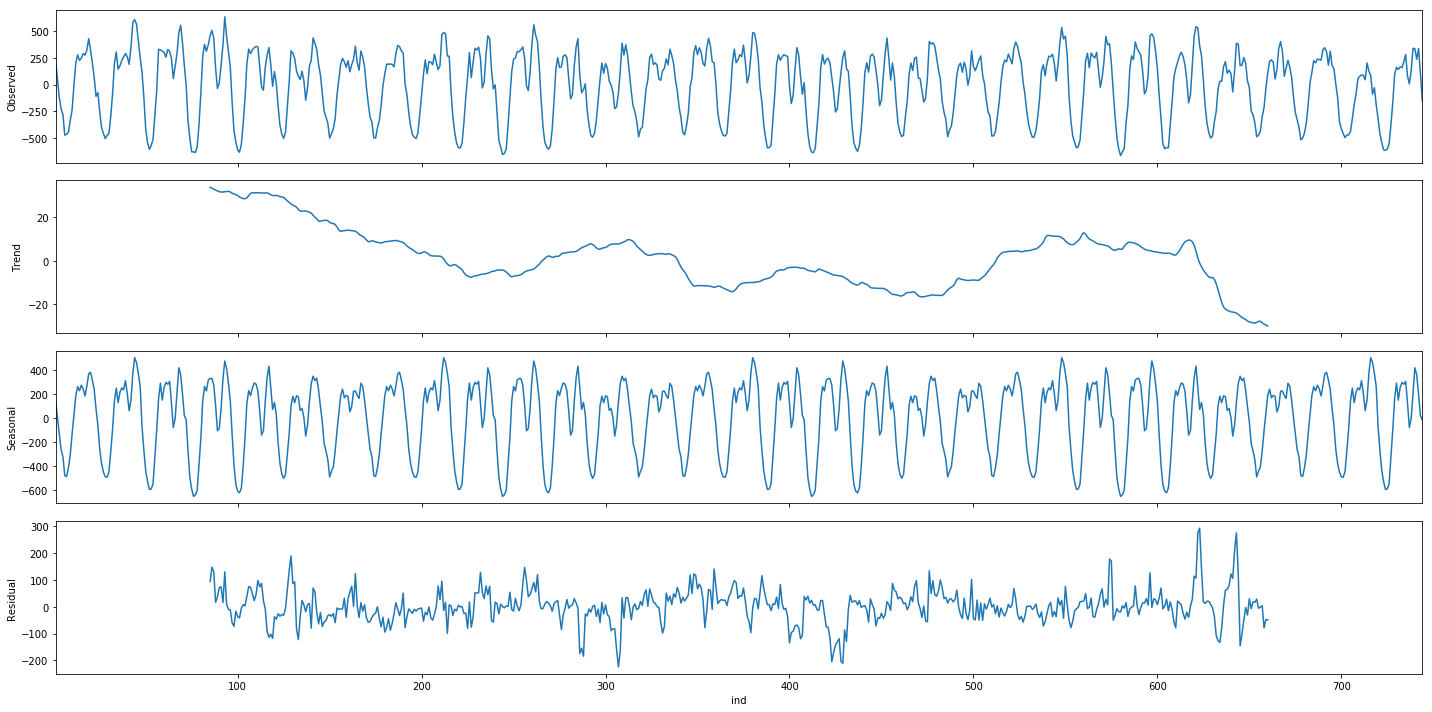

In [0]:
plt.figure(figsize(20,10))
sm.tsa.seasonal_decompose(data.resid.dropna(), freq = 24*7).plot()
print("Критерий Дики-Фуллера: p = %f" % sm.tsa.stattools.adfuller(data.resid)[1])


**Продифференцируем пару раз и посмотрим на декомпозицию:**

In [0]:
def make_difference(diff_data, diff_count, diff_period):
  result = pd.Series(diff_data)
  for _ in range(diff_count):
    result -= result.shift(diff_period)
  
  return result

In [0]:
data['resid_diff'] = make_difference(data.resid, 1, 24)
data['resid_diff'] = make_difference(data.resid_diff, 1, 1)

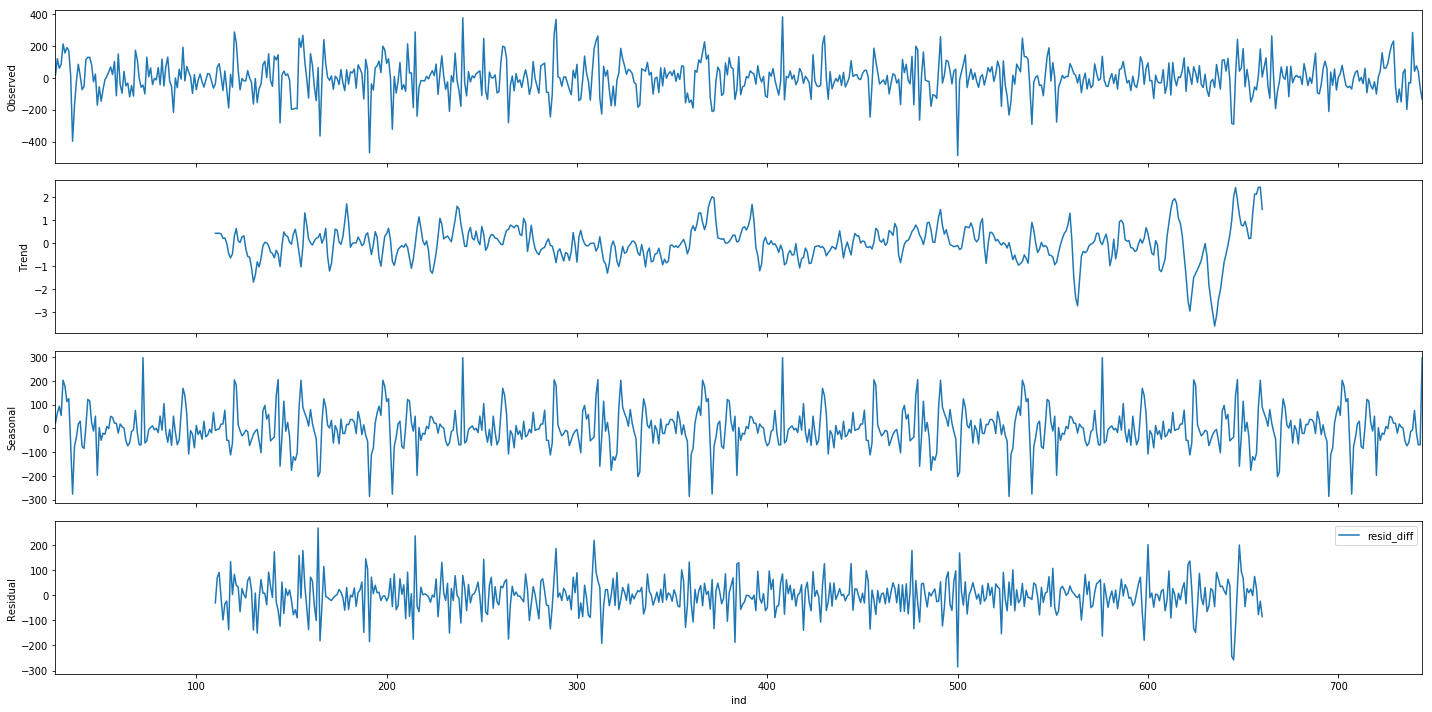

In [0]:
sm.tsa.seasonal_decompose(data.resid_diff.dropna(), freq = 24*7).plot()
legend()

**В остатках куча выбросов, оно и понятно - модель пока что их не учитывает. В остальном результат норм. В задании рекомендуют запускать ариму на исходных данных, подсовывая ей признаки параметром "Exog", но это очень долго. Поэтому я буду вычислять остатки от моделирования регрессионными признаками и запускать ариму на них. Для того чтобы получить результаты итогового моделирования мне нужно будет просто прибавить результат работы аримы к результату моделирования регресонными признаками (синусами-косинусами).**

**Выбираем начальные приближения:**

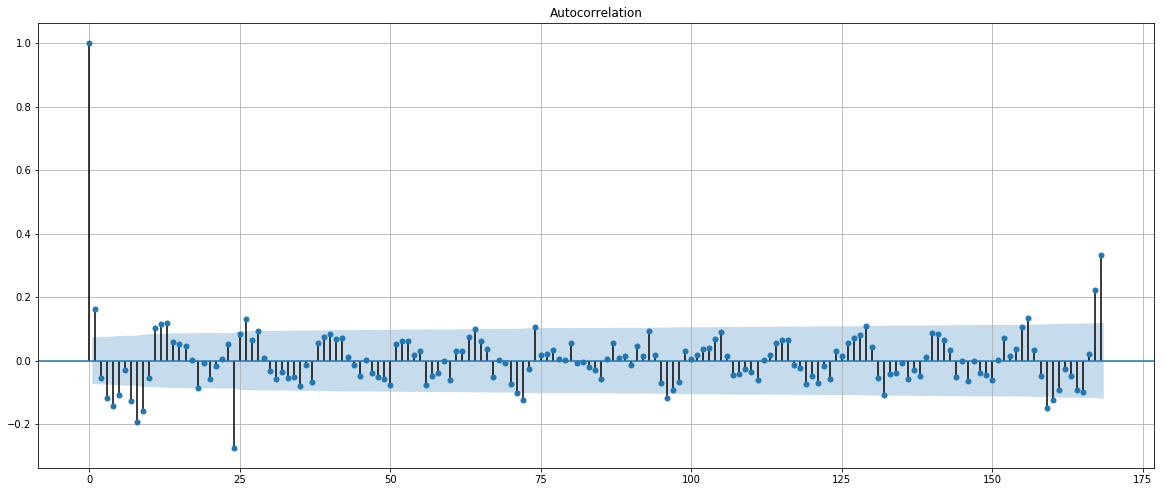

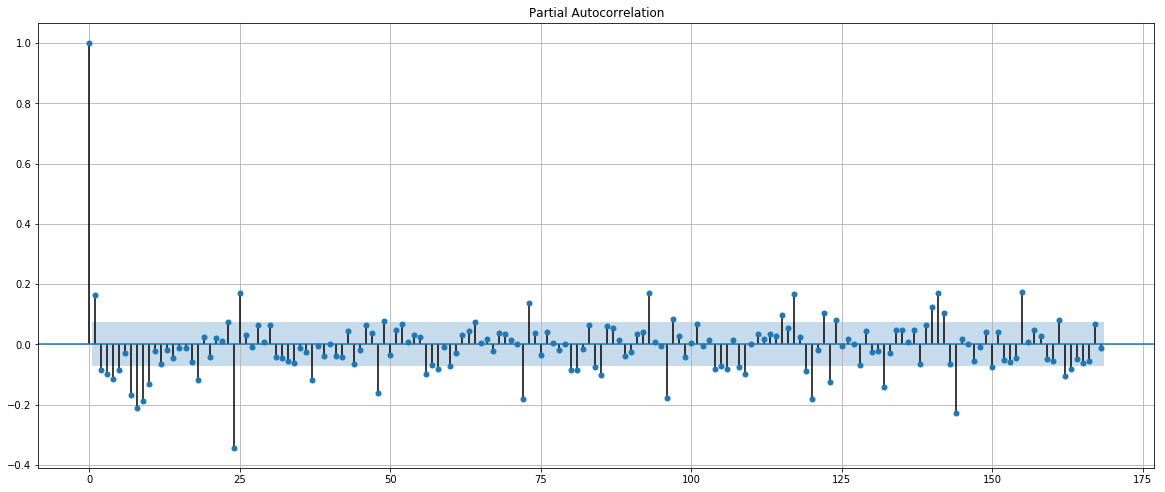

In [0]:
plt.figure(figsize(20, 18))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.resid_diff.dropna().values, lags=24*7, ax=ax)
ax.grid()
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.resid_diff.dropna().values, lags=24*7, ax=ax)
ax.grid()
pylab.show()

**По коррелограммам можно выбрать следующие начальные приближения: 
q = 13,
Q = 4,
p = 18,
P = 7, но делать так я конечно же не буду. Опять же - это очень долго. Я рассчитываю, что коррелограмма будет иметь другой вид, когда я введу дополнительные регресионные признаки, учитывающие выходные, праздники и тд. Поэтому выбираю начальные приближения такими:**

In [0]:
import itertools

p = range(0, 3)
q = range(0, 4)
P = range(0, 2)
Q = range(0, 2)

d=1
D=1

params = itertools.product(p, q, P, Q)
params_list = list(params)
print len(params_list), 'combinations'

48 combinations


**Запускаемся:**

In [0]:
%%time

from IPython.display import display, clear_output
from ipywidgets import IntProgress
progress_bar = IntProgress(value=15, min=0, max=48,     \
                           description='Processing...', \
                           bar_style='success')
display(progress_bar)
progress_bar.value = 0

results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in params_list:
    try:
        model=sm.tsa.statespace.SARIMAX(data.resid, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    except LinAlgError:
        print('LinAlgError:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    progress_bar.value += 1
    
warnings.filterwarnings('default')

IntProgress(value=15, bar_style=u'success', description=u'Processing...', max=48)

CPU times: user 19min 45s, sys: 26min 20s, total: 46min 5s
Wall time: 11min 44s


In [0]:
best_model.aic

8346.536946952205

**Получаем итоговую модель - складываем результаты моделирования аримой с результатами моделирования регрессионными признаками:**

In [0]:
data['pred'] = data['predicts'] + best_model.fittedvalues

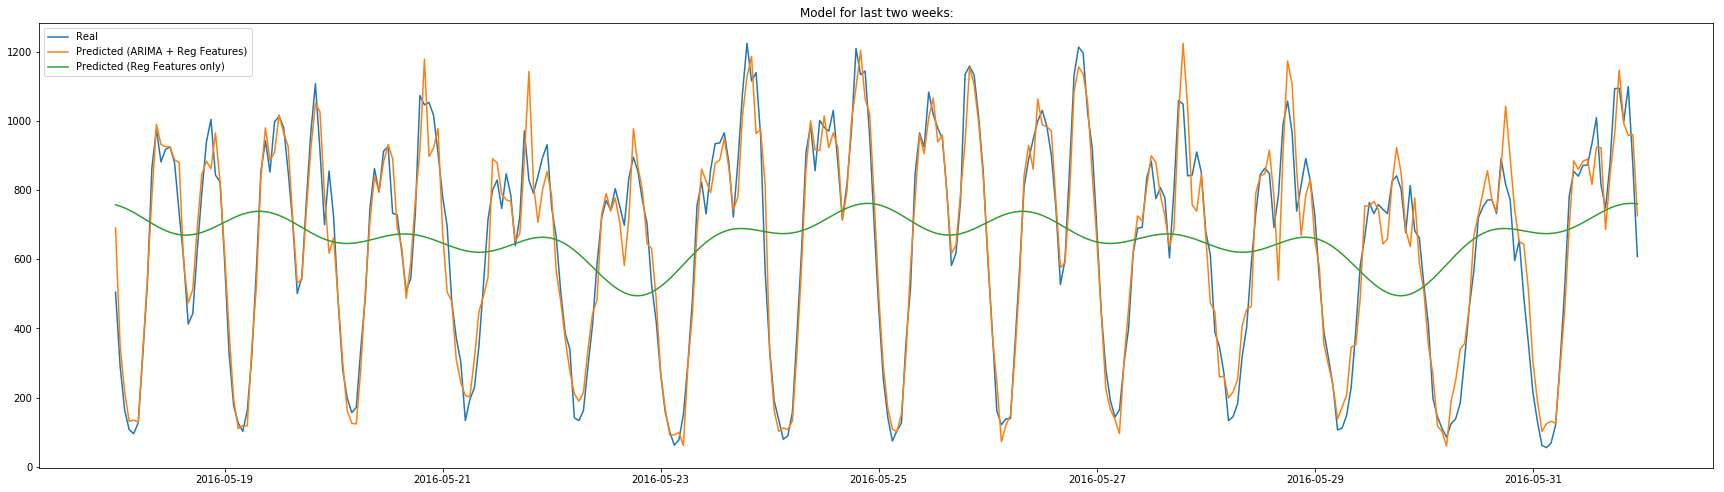

In [0]:
plt.figure(figsize(30, 18))
ax = plt.subplot(211)
plt.plot(data.time[-24*14:], data['trips'][-24*14:])
plt.plot(data.time[-24*14:], data['pred'][-24*14:])
plt.plot(data.time[-24*14:], data['predicts'][-24*14:])
plt.title('Model for last two weeks:')
plt.legend(['Real', 'Predicted (ARIMA + Reg Features)', 'Predicted (Reg Features only)'])

**С ходу получаем в принципе неплохой результат, учитывая что начальные приближения для аримы подбирались из принципа "чтоб быстрее крутилось". Попробую увеличить количество синусов-косинусов, а также добавлю еще один признак-полином: "pol_feat = n ** i", где "n" - порядковый номер часа, а "i" - количество регрессионных признаков в модели.**

In [0]:
datasets_path = '/content/drive/My Drive/Colab Notebooks/data/agregated/'
data_files    = sorted(os.listdir(datasets_path))

def make_dataset(data_files, month_amount):
  datasets = []
  print 'Using files:'
  for file in data_files[-month_amount:len(data_files)]:
    print '\t', file
    dataset = pd.read_csv(datasets_path + file)
    dataset = dataset[['Unnamed: 0', 'Region_1231']]
    dataset.columns = ['time', 'trips']
    dataset.time = pd.to_datetime(dataset.time)
    datasets.append(dataset)
  
  data = pd.concat(datasets)
  data['ind'] = range(1, data.shape[0] + 1)
  data = data.set_index('ind')
    
  return data

data = make_dataset(data_files, 1)

print 'Done!'

def generate_feats(df, k):
  feat_columns = []
  for i in range(1, k+1):
    sin_feat_name = 'week_sin_' + str(i)
    cos_feat_name = 'week_cos_' + str(i)
    pol_feat_name = 'pol_' + str(i)
    feat_columns.append(sin_feat_name)
    feat_columns.append(cos_feat_name)
    feat_columns.append(pol_feat_name)
    if sin_feat_name not in df.columns:
      df[sin_feat_name] = np.sin(np.array((df.index + 1) * 2 * np.pi * i / 168))
    if cos_feat_name not in df.columns:
      df[cos_feat_name] = np.cos(np.array((df.index + 1) * 2 * np.pi * i / 168))
    if pol_feat_name not in df.columns:
      df[pol_feat_name] = (df.index + 1) ** i

  return feat_columns


def make_linreg(df, k):
  feats = generate_feats(df, k)
  X = np.array(df[feats])
  y = np.array(df.trips)
  linreg = LR().fit(X, y)
  predicts = linreg.predict(df[feats])
  df['predicts'] = np.array(predicts, dtype='float32')
  df['resid'] = df.trips - predicts
  
  return predicts   

Using files:
	agr_yellow_tripdata_2016-05.csv
Done!


In [0]:
  make_linreg(data, 8)


In [2]:
%%time
import warnings
from IPython.display import display, clear_output
from ipywidgets import IntProgress
progress_bar = IntProgress(value=15, min=0, max=48,     \
                           description='Processing...', \
                           bar_style='success')
display(progress_bar)
progress_bar.value = 0

results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in params_list:
    try:
        model=sm.tsa.statespace.SARIMAX(data.resid, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    except np.linalg.LinAlgError:
        print('LinAlgError:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    progress_bar.value += 1
    
warnings.filterwarnings('default')

IntProgress(value=15, bar_style=u'success', description=u'Processing...', max=48)

NameError: ignored

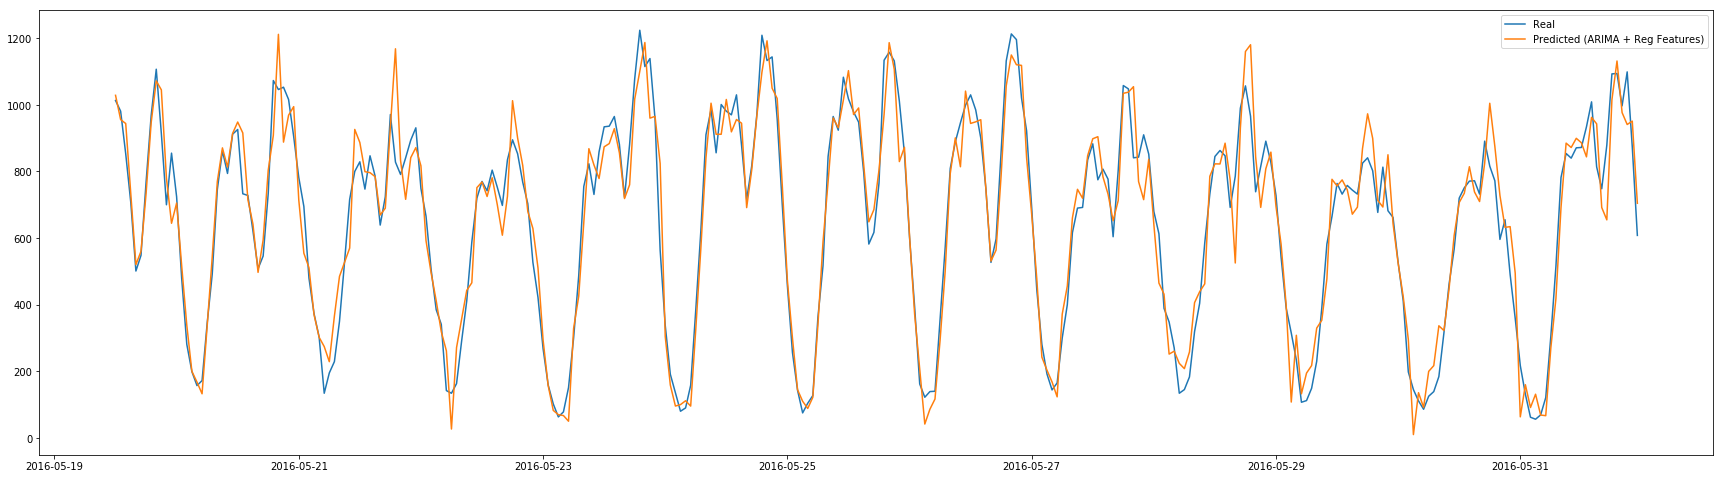

In [0]:
plt.figure(figsize(30, 18))
ax = plt.subplot(211)
plt.plot(data.time[-300:], data['trips'][-300:])
plt.plot(data.time[-300:], data['pred'][-300:])
plt.legend(['Real', 'Predicted (ARIMA + Reg Features)'])

**Где-то стало лучше, где-то хуже, в целом результат не особо изменился. Пока оставлю так.**